## Adagrad——从零开始
在我们之前介绍过的优化算法中，无论是梯度下降、随机梯度下降、小批量随机梯度下降还是使用动量法，目标函数自变量的每一个元素在相同时刻都使用同一个学习率来自我迭代。

举个例子，假设目标函数为$f$，自变量为一个多维向量$[x_1, x_2]^\top$，该向量中每一个元素在更新时都使用相同的学习率。例如在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：

$\begin{split}x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \\
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.\end{split}$.

如果让$x_1$和$x_2$使用不同的学习率自我迭代呢？实际上，Adagrad就是一个在迭代过程中不断自我调整学习率，并让模型参数中每个元素都使用不同学习率的优化算法。

下面，我们将介绍Adagrad算法。关于本节中涉及到的按元素运算，例如标量与向量计算以及按元素相乘$\odot$，请参见“数学基础”一节。

### Adagrad算法
Adagrad的算法会使用一个小批量随机梯度按元素平方的累加变量$\boldsymbol{s}$，并将其中每个元素初始化为0。在每次迭代中，首先计算小批量随机梯度$\boldsymbol{g}$，然后将该梯度按元素平方后累加到变量$\boldsymbol{s}$：

$\boldsymbol{s} \leftarrow \boldsymbol{s} + \boldsymbol{g} \odot \boldsymbol{g}.$

然后，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$\boldsymbol{g}^\prime \leftarrow \frac{\eta}{\sqrt{\boldsymbol{s} + \epsilon}} \odot \boldsymbol{g},$

其中$\eta$是初始学习率且$\eta>0$，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-7}$。我们需要注意其中按元素开方、除法和乘法的运算。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

最后，自变量的迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime.$

### Adagrad的特点
需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}$出现在含调整后学习率的梯度$\boldsymbol{g}^\prime$的分母项。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么就让该元素的学习率下降快一点；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么就让该元素的学习率下降慢一点。然而，由于$\boldsymbol{s}$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，Adagrad在迭代后期由于学习率过小，可能较难找到一个有用的解。

### Adagrad的实现
Adagrad的实现很简单。我们只需要把上面的数学公式翻译成代码。



In [33]:
def adagrad(params, grads, sqrs, lr, batch_size):
    for param, grad, sqr in zip(params, grads, sqrs):
        sqr += np.multiply(grad, grad)
        param[:] -= lr * grad / np.sqrt(sqr + 1e-12)
    return params, sqrs

## 实验
首先，导入本节中实验所需的包。

In [34]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import numpy as np
import random

sys.path.append('..')

实验中，我们以之前介绍过的线性回归为例。设数据集的样本数为1000，我们使用权重w为[2, -3.4]，偏差b为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

In [35]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = np.random.normal(scale=1, size=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * np.random.normal(scale=1, size=y.shape)

# 初始化模型参数。
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros((1,))
    sqrs = []
    params = [w, b]
    for param in params:
        sqrs.append(np.zeros(param.shape))
    return params, sqrs

# 构造迭代器。
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = np.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X[j], y[j]

# 线性回归模型。
def net(X, w, b):
    return np.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - np.reshape(y, yhat.shape)) ** 2 / 2

def cal_grad(yhat, y, X):
    grad_w = np.expand_dims(np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0]), -np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 1])]), axis=1)
    #grad_w = np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0])])
    grad_b = -np.sum((yhat - np.reshape(y, yhat.shape)))
    return [grad_w, grad_b]

优化函数optimize与“梯度下降和随机梯度下降——从零开始”一节中的类似。

In [36]:
import matplotlib as mpl

import matplotlib.pyplot as plt

def train(batch_size, lr, epochs, period):
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y))]
    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 学习率自我衰减。
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            output = net(data, w, b)
            loss = square_loss(output, label)
            grad =  cal_grad(label, output, data)
            [w, b], sqrs = adagrad([w, b], grad, sqrs, lr, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(
                    np.mean(square_loss(net(X, w, b), y)))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w, (1, -1)),
          'b:', b, '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    mpl.rcParams['figure.figsize'] = 3.5, 2.5
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

最终，优化所得的模型参数值与它们的真实值较接近。



Batch size 10, Learning rate 0.900000, Epoch 1, loss 5.0670e-05
Batch size 10, Learning rate 0.900000, Epoch 2, loss 5.0783e-05
Batch size 10, Learning rate 0.090000, Epoch 3, loss 5.0440e-05
('w:', array([[ 1.99940148, -3.39987093]]), 'b:', array([4.2001182]), '\n')


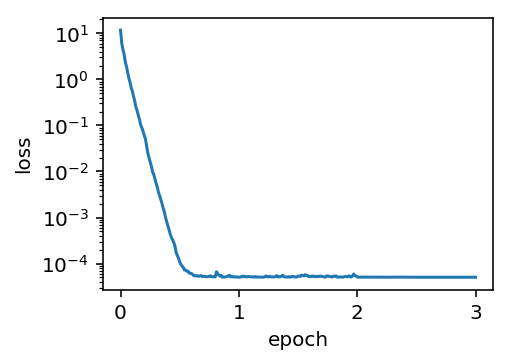

In [38]:
train(batch_size=10, lr=0.9, epochs=3, period=10)
